In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

import pastas as ps
from scipy import stats
ps.show_versions()
import emcee
import corner

import logging, sys
logging.disable(sys.maxsize)

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.2
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0
LMfit version: 1.3.1
Latexify version: Not Installed
Pastas version: 1.5.0


Definition of the extremes of calibration and validation periods according to the Groundwater Challenge instructions.  
- Calibration period: data used to fit the model.  
- Validation period: data used to test the model's predictive performance.

In [2]:
tmin_cal = "2000-01-01"
tmax_cal = "2015-09-10"
tmin_val = "2016-01-01"
tmax_val = "2021-12-31"

Function to import and display of dependent and independent time series.

In [3]:
heads_full =  pd.read_csv("data/heads_full.csv", index_col=0, parse_dates=True).squeeze()

In [4]:
def read_data(path_head, path_stresses): 
    head = pd.read_csv(path_head, index_col=0, 
                       parse_dates=True).squeeze()
    
    stresses = pd.read_csv(path_stresses, index_col=0, 
                   parse_dates=True).squeeze()
    
    prec = stresses.iloc[:, 0].rename("prec").dropna()
    evap = stresses.iloc[:, 8].rename("evap").dropna()
    av_temp = stresses.iloc[:, 1].rename("av_temp").dropna()

    axes = ps.plots.series(
        head=head,
        stresses=[prec, evap],
        tmin="2000",
        labels=["Head\n[m]", "Prec\n[mm/d]", "Evap\n[mm/d]"],
    )
    return head, prec, evap, av_temp, stresses

- `head`: Time series data of observed groundwater head levels, loaded from a CSV file.
- `stresses`: Time series data of various stressors, loaded from a CSV file.
Data is indexed by dates for time series analysis.  
This specific stresses dataset includes: 
- Precipitation data stored in the `prec` variable in [mm/day].
- Evaporation data stored in the `evap` variable in [mm/day].  
Two different head datasets are provided, they are both imported, nonetheless, they are the exact same and cover the totality of the avaiable head observations.  

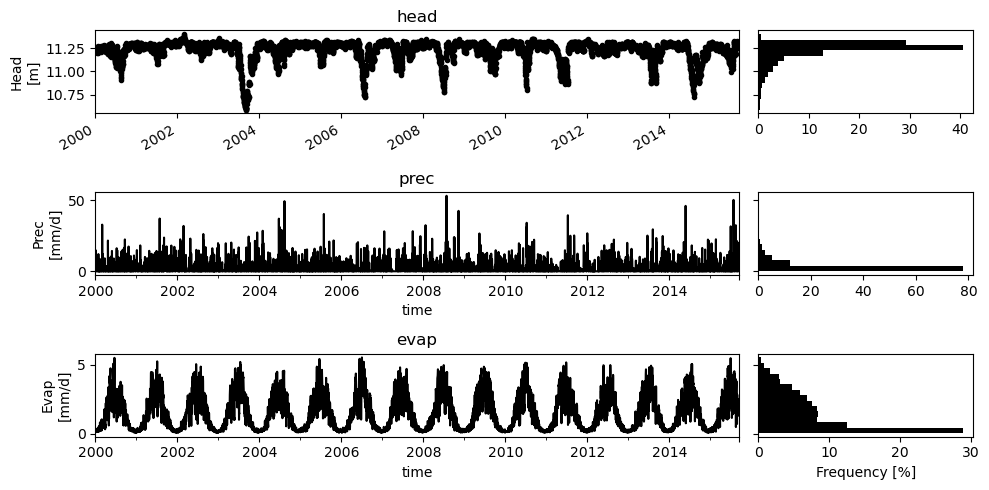

In [5]:
path_head = "data/heads.csv"
path_stresses = "data/input_data.csv"
head, prec, evap, av_temp, stresses = read_data(path_head, path_stresses)

This plot provides a summary of the observed groundwater head levels and stressors over time.
The visualization helps identify trends and patterns before model fitting, as well as getting a first idea of the order of magnitude of the head levels and stressors.

Using the complete head observations dataset, two subsets are created, one covering the calibration period (`head_cal`) and one covering the validation period (`head_val`).

In [6]:
head_cal = head[(head.index >= tmin_cal) & (head.index <= tmax_cal)]
head_val = heads_full[(heads_full.index >= tmin_val) & (heads_full.index <= tmax_val)]

Validation of imported datasets. This is done to make sure they meet the requirements to be used in PASTAS models.

In [7]:
ps.validate_oseries(head)
ps.validate_stress(prec)
ps.validate_stress(evap)

True

First a non linear recharge model is built with a Gamma response function.

Fit report head                    Fit Statistics
nfev    133                    EVP          39.81
nobs    5696                   R2            0.40
noise   True                   RMSE          0.09
tmin    2000-01-01 00:00:00    AICc     -44872.19
tmax    2015-09-10 00:00:00    BIC      -44819.03
freq    D                      Obj           1.08
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (8 optimized)
                  optimal     initial   vary
rch_A            0.213922    0.646063   True
rch_n            0.010000    1.000000   True
rch_a        10000.000000   10.000000   True
rch_srmax       59.741709  250.000000   True
rch_lp           0.250000    0.250000  False
rch_ks           1.397524  100.000000   True
rch_gamma        0.480760    2.000000   True
rch_kv           1.000000    1.000000  False
rch_simax        2.000000    2.000000  False
constant_d      11.025341   11.225948   True
noise_alpha     37.022702    

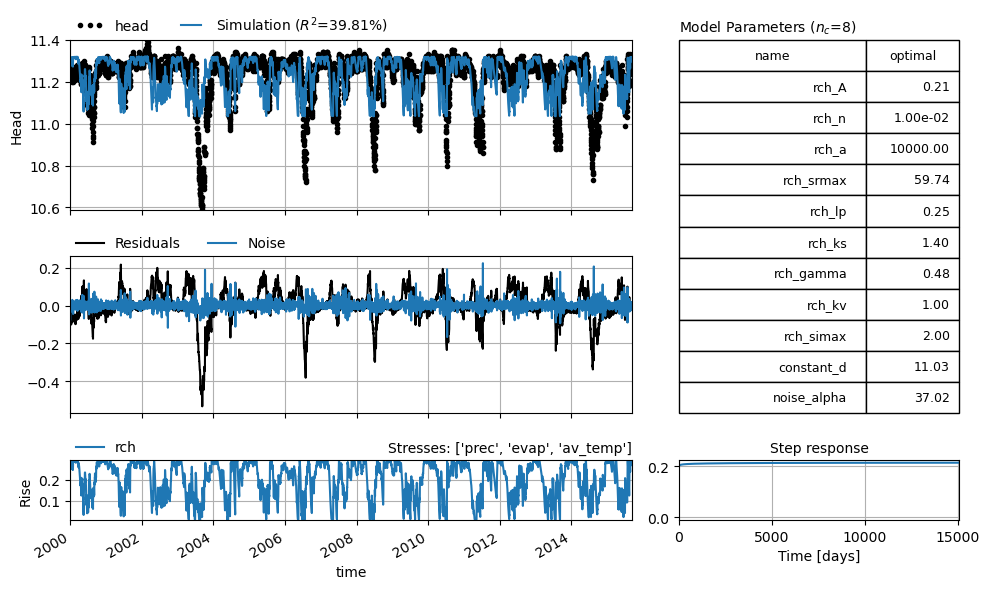

In [8]:
ml = ps.Model(head)
ml.add_noisemodel(ps.ArNoiseModel())
rch = ps.rch.FlexModel()
rch_m = ps.RechargeModel(prec, evap, rfunc=ps.Gamma(), recharge=rch, temp = av_temp,  name="rch")
ml.add_stressmodel(rch_m)
ml.solve(report=True, tmin=tmin_cal, tmax=tmax_cal)
axes = ml.plots.results(figsize=(10, 6))

The fit is poor, the type of recharge model is changed, a Tarso model is used.
With the Tarso Model the fit is increased up to 73%.

Fit report head                    Fit Statistics
nfev    46                     EVP          73.83
nobs    5696                   R2            0.74
noise   True                   RMSE          0.06
tmin    2000-01-01 00:00:00    AICc     -42413.04
tmax    2015-09-10 00:00:00    BIC      -42353.24
freq    D                      Obj           1.66
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                optimal    initial  vary
rch_A0         0.779070   0.205831  True
rch_a0       360.366588  10.000000  True
rch_d0        12.272778  10.995000  True
rch_A1         0.015317   0.205831  True
rch_a1        21.960195  10.000000  True
rch_d1        11.194424  11.197500  True
rch_f         -1.513511  -1.000000  True
constant_d     0.048581  11.225948  True
noise_alpha    9.764909   1.000000  True


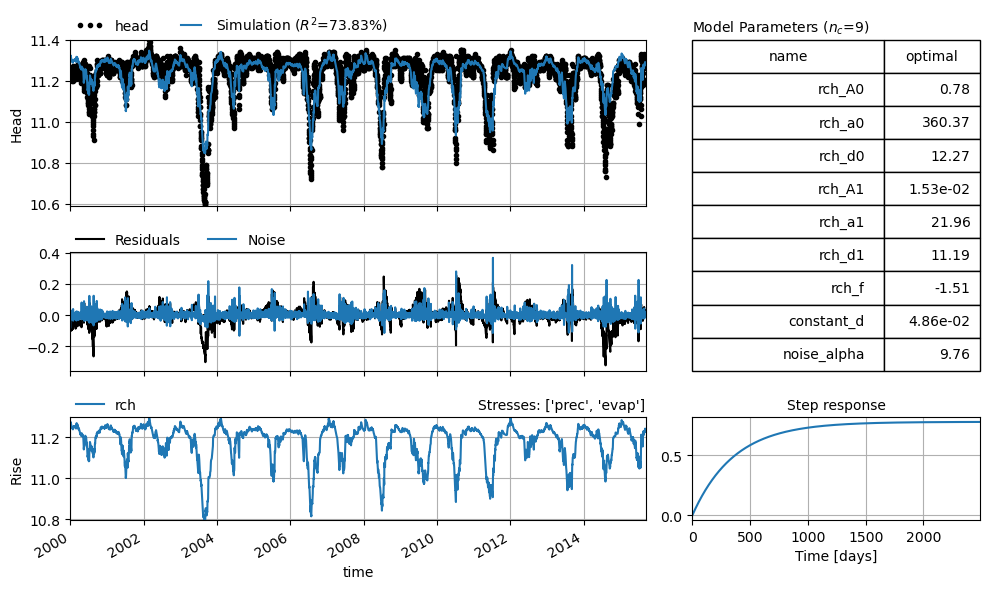

In [9]:
ml = ps.Model(head, constant = True)
ml.add_noisemodel(ps.ArNoiseModel())

rch_m = ps.TarsoModel(prec, evap, oseries = head, name="rch")
ml.add_stressmodel(rch_m)
ml.solve(report=True, tmin=tmin_cal, tmax=tmax_cal)
axes = ml.plots.results(figsize=(10, 6))

In [10]:
for name in ml.parameters.index:
    ml.set_parameter(name, dist="norm", vary = True)

ml.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
rch_A0,0.205831,0.00001,20.583129,True,rch,norm,0.281375,0.779070
rch_a0,10.000000,0.01000,1000.000000,True,rch,norm,132.265280,360.366588
rch_d0,10.995000,NaN,NaN,True,rch,norm,14936.858481,12.272778
rch_A1,0.205831,0.00001,20.583129,True,rch,norm,0.002198,0.015317
rch_a1,10.000000,0.01000,1000.000000,True,rch,norm,2.537556,21.960195
rch_d1,11.197500,10.59000,11.400000,True,rch,norm,14936.792893,11.194424
rch_f,-1.000000,-2.00000,0.000000,True,rch,norm,0.081217,-1.513511
constant_d,11.225948,NaN,NaN,True,constant,norm,14936.793230,0.048581
noise_alpha,1.000000,0.00001,5000.000000,True,noise,norm,0.616292,9.764909


In [11]:
heads_sim = ml.simulate(tmin = tmin_cal, tmax = tmax_val)
sim_cal = ml.simulate(tmin = tmin_cal, tmax = tmax_cal) 
sim_val = ml.simulate(tmin = tmin_val, tmax = tmax_val) 

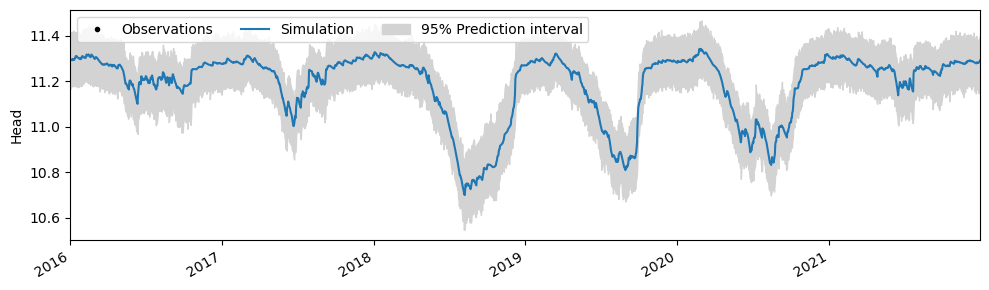

In [12]:
ci_val = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_val, tmax = tmax_val)
ci_cal = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_cal)
ci_tot = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_val)
ax = ml.plot(figsize=(10, 3), tmin = tmin_val, tmax = tmax_val)
ax.fill_between(ci_val.index, ci_val.iloc[:, 0], ci_val.iloc[:, 1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)

A comprehensive plot is provided including:
- scatter plot of observed head values over the total period (2000 - 2022).
- simulated head over the total period (2000 - 2022).
- 95% prediction interval over the validation period (2017 - 2022).

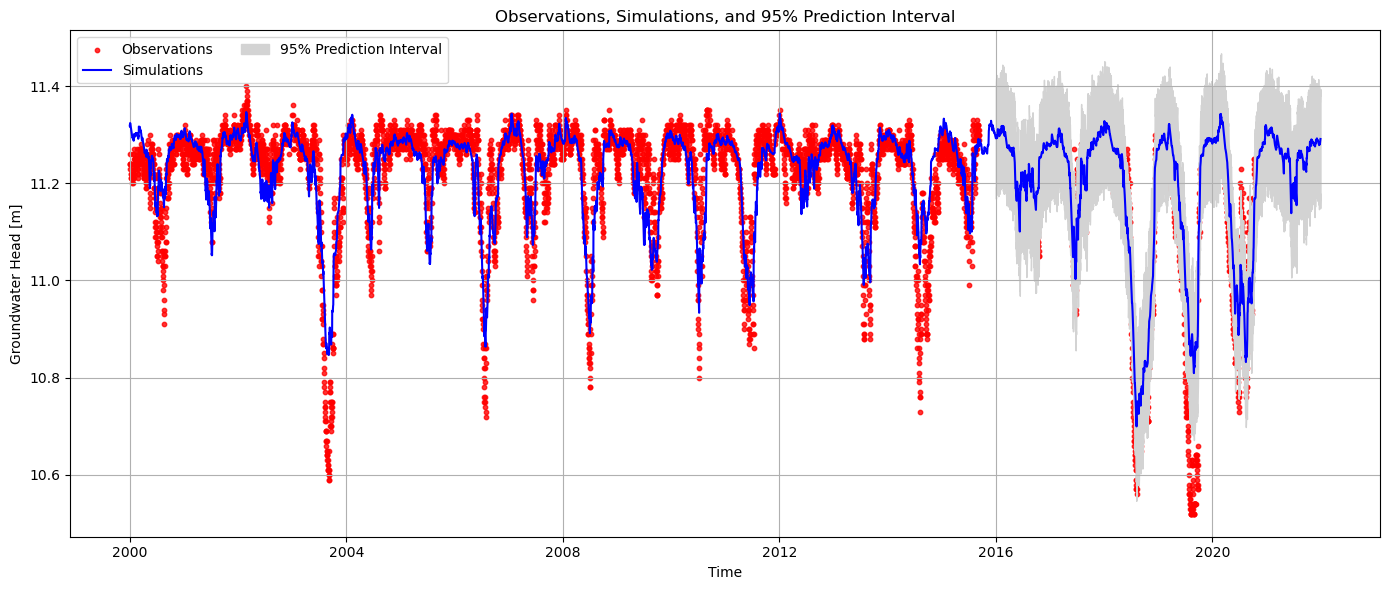

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))


ax.scatter(
    heads_full.index,
    heads_full,
    label="Observations",
    color="red",
    s=10, 
    alpha=0.8,
)


ax.plot(
    heads_sim.index,
    heads_sim,
    label="Simulations",
    color="blue",
    linewidth=1.5,
)


ax.fill_between(
    ci_val.index,
    ci_val.iloc[:, 0],
    ci_val.iloc[:, 1],
    color="lightgray",
    label="95% Prediction Interval",
)


ax.set_title("Observations, Simulations, and 95% Prediction Interval")
ax.set_xlabel("Time")
ax.set_ylabel("Groundwater Head [m]")
ax.legend(loc="upper left", ncol=2)
ax.grid()

plt.show()


**Diagnostics checking**

A diagnostics check is performed on the noise series of the model. This is done to ensure that the model adequately describes the observed time series.

The check is conducted to test the assumptions for white noise:
- No significant autocorrelation;
- Residuals are homoscedastic;
- Residuals follow a normal distribution.

The results of the diagnostics check show that all tests reject the null hypothesis, meaning that the data do not agree with the assumptions.

In [14]:
ml.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0 ($\alpha$=0.05)
Shapiroo,Normality,0.77,0.00,True
D'Agostino,Normality,4425.41,0.00,True
Runs test,Autocorr.,7.92,0.00,True
Stoffer-Toloi,Autocorr.,401.75,0.00,True


**Reducing autocorrelation**

Autocorrelation is computed and displayed for time lags from 1 to 365 days. The autocorrelation plot shows that for the first 10-15 days the correlation between the observations is very close to one, it then drops significantly at around 20 days.

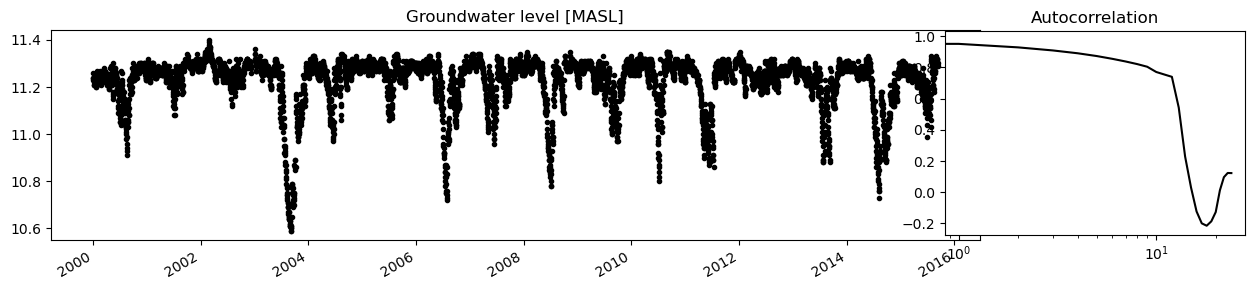

In [15]:
ax = head.plot(figsize=(10, 3), marker=".", linestyle=" ", color="k")
ax1 = plt.axes([0.95, 0.2, 0.3, 0.68])
acf = ps.stats.acf(
    head,
    lags=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        12,
        13,
        14,
        30,
        61,
        90,
        120,
        150,
        180,
        210,
        240,
        270,
        300,
        330,
        365,
    ],
).values
ax1.semilogx(acf, color="k")
ax.set_title("Groundwater level [MASL]")
ax1.set_title("Autocorrelation");

In [16]:
mls_ar = {}
dts = 21


for dt in range(1, dts, 2):
  
    ml_name = f"NL_{dt}"
    ml = ps.Model(head.iloc[::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())

    sm = ps.TarsoModel(prec, evap, oseries = head, name="rch")
    ml.add_stressmodel(sm)

    
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_ar[ml_name] = ml

The previously created groundwater models (`mls_ar`) are changed to analyze the impact of changing the noise model from autoregressive (AR) to autoregressive-moving-average (ARMA). The modified models are then calibrated and stored for comparison.

Outputs:
- Recalibrated models stored in `mls_arma`.
- Each model is identical to the one in `mls_ar`, except for the noise model type (ARMA instead of AR).

--> a decision can be made about the type of noise model to use.

In [17]:
mls_arma = {}

for ml_name, ml in mls_ar.items():
    ml = ml.copy(name=ml.name)

    ml.del_noisemodel()
    ml.add_noisemodel(ps.ArmaNoiseModel())

    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_arma[ml_name] = ml

The performance of different noise models (AR and ARMA) is evaluated by computing the Durbin-Watson (DW) statistic. The results are plotted to compare the two noise models at varying temporal resolutions (`dt`).

1. **Data preparation**
- Two empty DataFrames (`data` and `data2`) are initialized to store the DW statistic for each temporal resolution (`dt`) and noise model.

2. **Compute DW statistic for AR noise models**
- Loop through all models in `mls_ar` (models with AR noise)

3. **DW statistic for ARMA noise models**
- Loop through all models in `mls_arma` (models with ARMA noise)

4. **Results**
- Two subplots (`ax1` and `ax2`) for AR and ARMA noise models are created, respectively:
  - **AR(1) Noise Model**:
    - Plot of DW statistics from `data` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.
  - **ARMA(1,1) Noise Model**:
    - Plot pf DW statistics from `data2` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.


The Durbin-Watson statistic is used as the metric:
- **DW = 2.0**: Indicates no autocorrelation.
- **DW < 2.0**: Indicates positive autocorrelation.

Outputs:
- **Two plots** comparing DW statistics for AR(1) and ARMA(1,1) noise models.
- Visual comparison of how the two noise models handle residual autocorrelation across varying temporal resolutions.


In this case, a model with a ARMA(1,1) noisemodel, with a 9 days time lag shows the lowest autocorrelation.

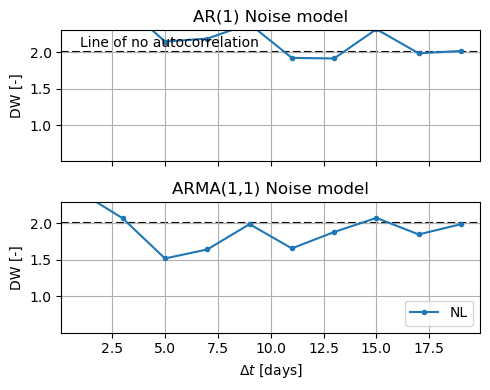

In [18]:
data = pd.DataFrame(index=range(dt, 1), columns=["NL"])

for ml in mls_ar.values():
    if "NL" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

data2 = pd.DataFrame(index=range(dt, 1), columns=["NL"])

for ml in mls_arma.values():
    if "NL" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data2.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(5, 4), sharey=True)

# AR1 Model
data.plot(ax=ax1, marker=".", legend=False)
ax1.set_ylabel("DW [-]")
ax1.axhline(2.0, c="k", linestyle="--", zorder=-1)
ax1.text(1, 2.07, "Line of no autocorrelation")
ax1.grid()
ax1.set_title("AR(1) Noise model")

# ArmaModel
data2.plot(ax=ax2, marker=".", legend=False)
ax2.set_ylabel("DW [-]")
ax2.set_yticks([1, 1.5, 2.0])
ax2.axhline(2.0, c="k", linestyle="--", zorder=-10)
ax2.set_ylim(0.5, 2.3)
ax2.grid()
ax2.legend(ncol=3, loc=4)
ax2.set_xlabel("$\\Delta t$ [days]")
ax2.set_title("ARMA(1,1) Noise model")
plt.tight_layout()

The model is solved with a 9 days time lag, with starting point varying from day to day for the first 9 days. An ARMA(1) noise model is added.

In [19]:
mls_with = {}
dt = 9


for start in range(0, dt, 1):
    ml_name = f"NL_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())

    sm = ps.TarsoModel(prec, evap, oseries = head, name="rch")
    ml.add_stressmodel(sm)

    
    ml.add_noisemodel(ps.ArmaNoiseModel())
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_with[ml_name] = ml

The same procedure is repeated without adding the noisemodel.

In [20]:
mls_without = {}
dt = 9


for start in range(0, dt, 1):
    ml_name = f"NL_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)


    sm = ps.TarsoModel(prec, evap, oseries = head, name="rch")
    ml.add_stressmodel(sm)

    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_without[ml_name] = ml

In this code cell the parameter estimates and uncertainties for models with and without noisemodels are organized in `df_with` and `df_without`.

In [21]:
data = {}

name = "NL"
ml = mls_with["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_with.values():
    if "NL" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]


df_with = pd.concat(data, axis=1)
df_with

NL                                                                    \
     rch_A0                    rch_a0                   rch_d0                  
        opt           std         opt           std        opt            std   
1  0.443788      0.073175   97.998461  1.600875e+01  11.141706       0.152182   
2  0.425225      0.072076   91.681185  1.505274e+01  11.268121   30173.177062   
3  0.449602      0.083277  100.056432  1.804108e+01  11.257255   28040.458958   
4  0.412754      0.052764   81.356765  1.013665e+01  11.070403   37324.049042   
5  0.439359      0.070642   94.582347  1.488164e+01  11.319649   24847.584290   
6  0.782305  14622.840560  694.382617  5.915966e+07  13.459760  374337.146291   
7  0.748151      0.172250  162.967999  3.720365e+01  11.312910       0.116347   
8  0.789251      0.209120  181.035041  4.730897e+01  11.271452   45941.759068   
9  0.687046      0.173554  151.469036  3.748122e+01  11.157153   17180.336293   

                                                                           \
     rch_A1                rch_a1                   rch_d1                  
        opt        std        opt           std        opt            std   
1  0.035171   0.005059  28.537366      3.556376  11.197575       0.133355   
2  0.027668   0.003461  18.498449      2.150890  11.198133   30173.165779   
3  0.031814   0.004290  22.500848      2.765997  11.198517   28040.445727   
4  0.055894   0.007069  54.471388      5.083793  11.202124   37324.056838   
5  0.038579   0.004737  30.221252      3.371527  11.196097   24847.562100   
6  0.061394  90.058577  26.056542  38222.527977  10.766536  384630.690761   
7  0.029691   0.003510  19.019557      2.091125  11.197516       0.081448   
8  0.027337   0.003668  18.968854      2.311390  11.197022   45941.737582   
9  0.021477   0.002873  13.258151      1.700088  11.197242   17180.320690   

                                                                        \
      rch_f           constant_d                noise_alpha              
        opt       std        opt            std         opt        std   
1 -0.868463  0.056221   0.024667       0.133366   86.107741  21.446012   
2 -0.943799  0.058092   0.030141   30173.165438   75.962099  17.076023   
3 -0.949954  0.063806   0.026400   28040.445252   72.873219  17.211875   
4 -0.870681  0.046082   0.014581   37324.057306   75.348087  16.872022   
5 -1.002441  0.062937   0.011519   24847.562206   86.463177  20.814597   
6 -1.193061  0.189476   0.217852  384624.355855   55.575434   9.272224   
7 -0.895831  0.054802   0.023071       0.081390   76.184765  17.179246   
8 -0.905830  0.055329   0.034587   45941.737286   75.537287  17.683632   
9 -0.807756  0.054508   0.038153   17180.320492   80.015740  18.159414   

                        
  noise_beta            
         opt       std  
1  -8.814480  1.151493  
2  -5.356397  0.811338  
3  -6.856531  0.945025  
4  -5.964004  0.853016  
5  -6.863616  0.909945  
6  -0.219047  0.000000  
7  -6.228425  0.879023  
8  -7.547740  1.010539  
9  -5.637551  0.829258

In [22]:
data = {}

name = "NL"
ml = mls_without["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_without.values():
    if "NL" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]

df_without = pd.concat(data, axis=1)
df_without

NL                                                            \
     rch_A0                rch_a0                rch_d0                 
        opt       std         opt        std        opt           std   
1  0.577847  0.096758  166.563504  29.453044  11.381345  20084.542277   
2  0.508803  0.073422  147.555185  22.558725  11.347188  22705.066083   
3  0.512651  0.072983  145.690474  22.140884  11.353118  13348.555513   
4  0.487031  0.065880  133.620439  19.125554  11.320265  13505.643635   
5  0.572100  0.088484  161.175033  26.721752  11.443498  17827.850861   
6  0.505148  0.075979  139.720739  22.541736  11.355083  16908.517301   
7  0.617950  0.095634  172.604440  28.540528  11.412808  18808.192583   
8  0.711879  0.128997  199.697139  38.371321  11.507437  24151.999159   
9  0.661550  0.113554  179.200030  32.833554  11.466232  23678.793646   

                                                                               \
     rch_A1               rch_a1               rch_d1                   rch_f   
        opt       std        opt       std        opt           std       opt   
1  0.018278  0.003098  40.855780  3.650447  11.126180  20084.522373 -1.163289   
2  0.019450  0.003071  42.720428  3.640969  11.193988  22705.042167 -1.113371   
3  0.019684  0.003131  44.995712  3.796080  11.197194  13348.567714 -1.121432   
4  0.020121  0.003213  46.483513  3.896541  11.199464  13505.636715 -1.102648   
5  0.018314  0.002960  41.990110  3.753177  11.197129  17827.878867 -1.155300   
6  0.022269  0.003358  48.730096  4.334715  11.196914  16908.488651 -1.135049   
7  0.018926  0.002889  40.467678  3.402182  11.195824  18808.205796 -1.119521   
8  0.018182  0.002884  38.214972  3.210776  11.195831  24152.004873 -1.136651   
9  0.023150  0.003229  46.888132  3.810743  11.200895  23678.820976 -1.129871   

                                      
            constant_d                
        std        opt           std  
1  0.055900   0.117314  20084.521696  
2  0.054886   0.050571  22705.042068  
3  0.053608   0.046600  13348.567806  
4  0.052178   0.043751  13505.636701  
5  0.055941   0.047045  17827.878743  
6  0.054374   0.042817  16908.488595  
7  0.049553   0.047725  18808.205627  
8  0.053238   0.047290  24152.004378  
9  0.055267   0.033688  23678.821036

### Parameter Variability Across Models

This code plots error bars to compare parameter variability across models with and without a noise model.

- Extracts models & parameters from `df_with`.
- Creates subplots for each parameter.
- Loops through parameters, checking for `opt` (optimized values) and `std` (standard deviation).
- Plots error bars for both datasets (`df_with` and `df_without`), showing uncertainty.
- Formats plots with labels, legends, grid lines, and a shared x-axis.
- Skips missing parameters and prints a message.

The result visualizes how the noise model affects different parameters as well as the influence of starting the simulation from different timesteps.

Skipping noise_alpha, columns not found in df_without.
Skipping noise_beta, columns not found in df_without.


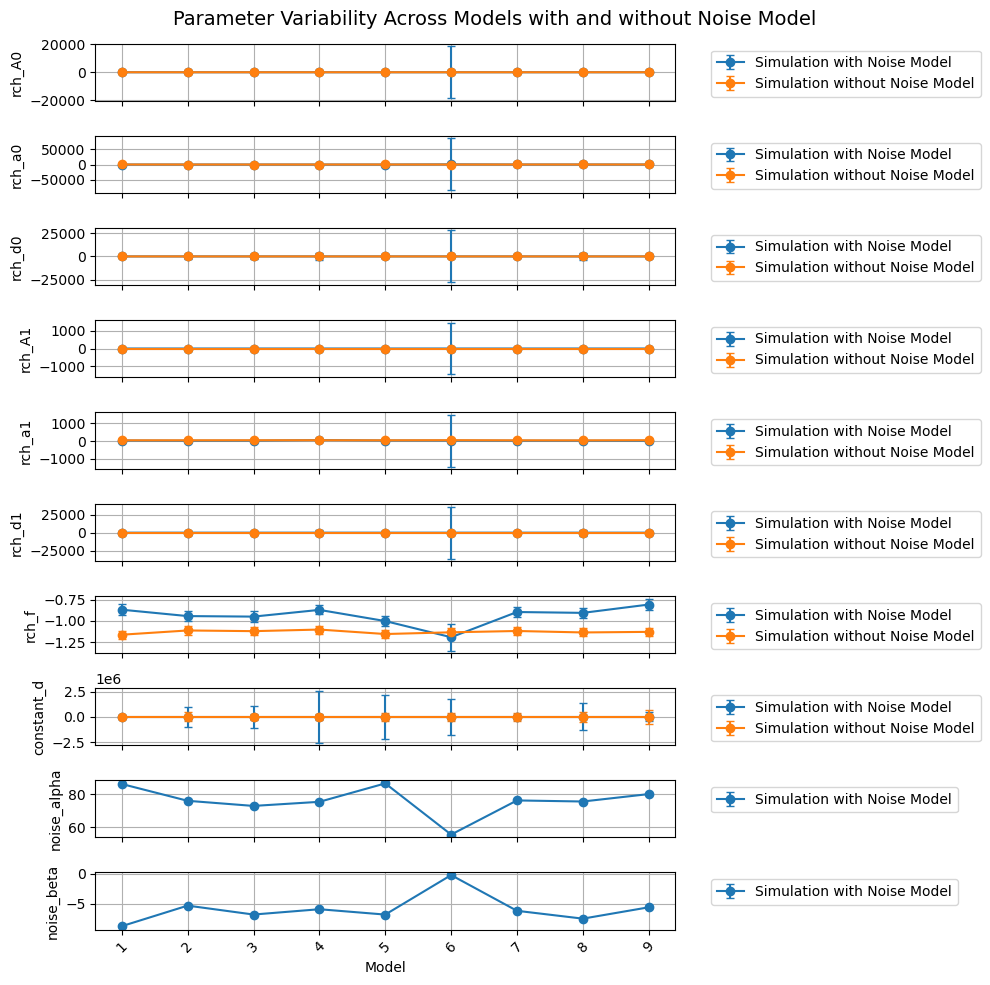

In [23]:
models = df_with.index
std_avg_with = []
std_avg_without = []
parameters = df_with["NL"].columns.get_level_values(0).unique()

fig, axes = plt.subplots(len(parameters), 1, figsize=(10, 10), sharex=True)

for i, param in enumerate(parameters):
    if ("NL", param, "opt") in df_with.columns and ("NL", param, "std") in df_with.columns:
        opt_with = df_with[("NL", param, "opt")]
        std_with = np.abs(df_with[("NL", param, "std")]/df_with[("NL", param, "opt")])
        std_avg_with.append(std_with.mean())

        axes[i].errorbar(df_with.index, opt_with, yerr=std_with, fmt="-o", capsize=3, label = "Simulation with Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df_with.")
        
    if ("NL", param, "opt") in df_without.columns and ("NL", param, "std") in df_without.columns:
        opt_without = df_without[("NL", param, "opt")]
        std_without = np.abs(df_without[("NL", param, "std")]/df_without[("NL", param, "opt")])
        std_avg_without.append(std_without.mean())

        axes[i].errorbar(df_without.index, opt_without, yerr=std_without, fmt="-o", capsize=3, label = "Simulation without Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df_without.")

axes[-1].set_xlabel("Model")
fig.suptitle("Parameter Variability Across Models with and without Noise Model", fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The uncertainty behind the parameters is quantified by computing the standard deviation for both models with and without the noisemodel. Please note the logarithmic scale on the y axis.

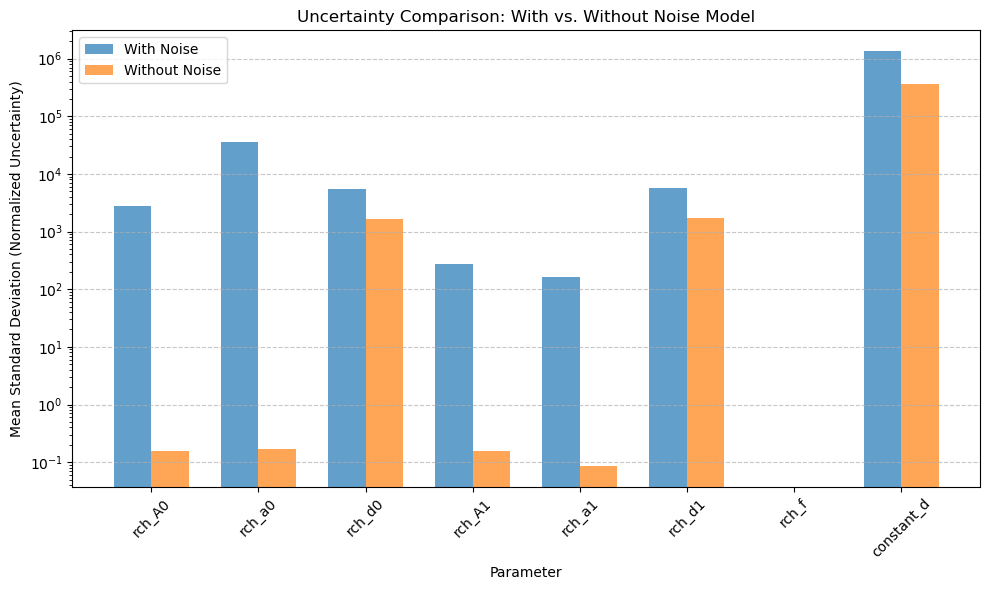

In [24]:
std_avg_with = [df_with[("NL", param, "std")].mean() / df_with[("NL", param, "opt")].mean()for param in parameters[:-2]]
std_avg_without = [df_without[("NL", param, "std")].mean() / df_without[("NL", param, "opt")].mean()for param in parameters[:-2]]


uncertainty_df = pd.DataFrame({
    "Parameter": parameters[:-2],
    "With Noise": std_avg_with,
    "Without Noise": std_avg_without
})


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(parameters[:-2]))

bars1 = ax.bar(index, std_avg_with, bar_width, label='With Noise', alpha=0.7)
bars2 = ax.bar(index + bar_width, std_avg_without, bar_width, label='Without Noise', alpha=0.7)

ax.set_xlabel('Parameter')
ax.set_ylabel('Mean Standard Deviation (Normalized Uncertainty)')
ax.set_title('Uncertainty Comparison: With vs. Without Noise Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(parameters[:-2], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

The statistical diagnostics of the previously calibrated groundwater models stored in the `mls_with` dictionary is performed.

In [25]:
for name, model in mls_with.items():
    print(f"Model name: {name}")
    print(model.stats.diagnostics(alpha=0.05))

Model name: NL_1
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.92    0.00                       True
D'Agostino     Normality    105.78    0.00                       True
Runs test      Autocorr.     -0.83    0.40                      False
Stoffer-Toloi  Autocorr.      4.36    0.99                      False
Model name: NL_2
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.96    0.00                       True
D'Agostino     Normality     39.17    0.00                       True
Runs test      Autocorr.      0.20    0.84                      False
Stoffer-Toloi  Autocorr.      5.17    0.97                      False
Model name: NL_3
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.96    0.00                       True
D'Agostino     Normality     49.29    0.00                       True
Runs test      Autocorr.     -1.95    0

Autocorrelation is visually inspected and a stoffer-toloi check is computed, both showing positive results, there is no significant autocorrelation in the noise.

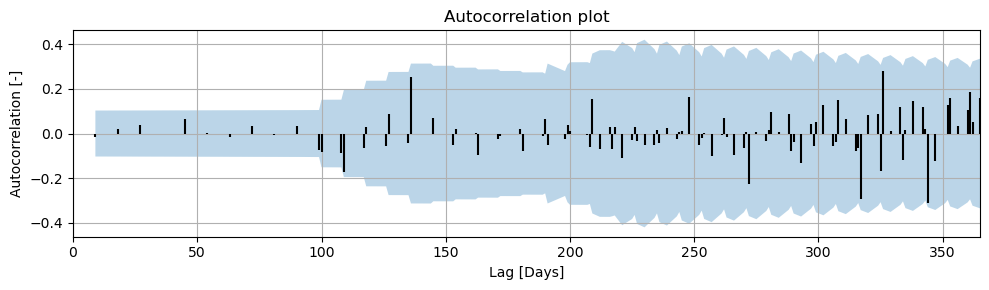

In [26]:
model_with = mls_with["NL_1"]
model_without = mls_without["NL_1"]
noise = model_with.noise()
ax = ps.plots.acf(noise, acf_options=dict(bin_width=0.5), figsize=(10, 3), alpha=0.01)

In [27]:
stat, p = ps.stats.stoffer_toloi(noise, lags=15)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, no significant autocorrelation. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Failed to reject the Null-hypothesis, no significant autocorrelation. p = 1.0


**Normality Checking**

Normality is checked visually by looking at the probability plot and at the histogram of he residuals with a normal distribution fit to it.

Most points on the probability plot lie close to the line of perfect normality, deviations are present at the tails, suggesting presence of non-normality in the residuals.

The histogram appears to be symmetric.

Nonetheless, normality cannot be confirmed by applying hypothesis testing, as the null-hypothesis of the normality check is rejected.

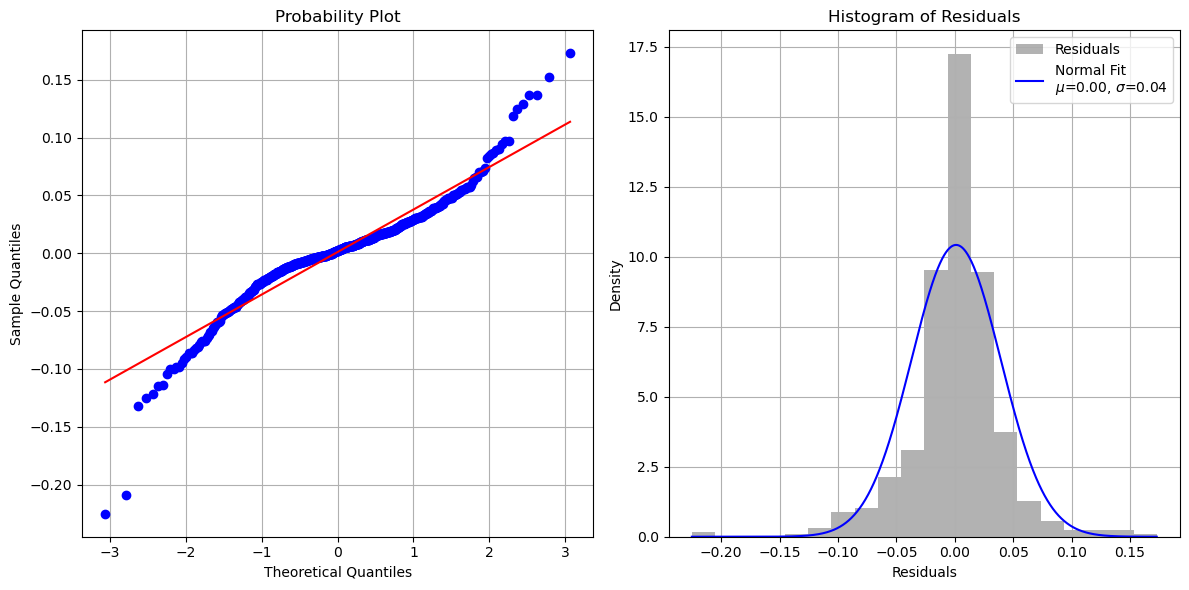

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


stats.probplot(noise, dist="norm", plot=axes[0])
axes[0].set_title("Probability Plot")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")
axes[0].grid()

axes[1].hist(noise, bins=20, density=True, alpha=0.6, color="gray", label="Residuals")


mu, std = stats.norm.fit(noise)
x = np.linspace(min(noise), max(noise), 1000)
pdf = stats.norm.pdf(x, loc=mu, scale=std)
axes[1].plot(x, pdf, color="blue", label=f"Normal Fit\n$\mu$={mu:.2f}, $\sigma$={std:.2f}")
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [29]:
stat, p = stats.normaltest(noise)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0


**Homoscedasticity Checking**
The hypothesis of homoscedasticity can be visually inspected by plotting the model residuals against the simulated groundwater level values. The points seem to cluster around 0 with some spread which does not present a sistematic trend, suggesting that the hypothesis could be confirmed.

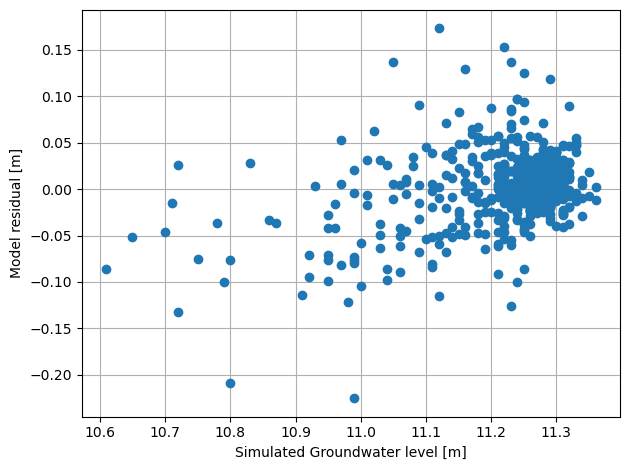

In [30]:
plt.plot(model_with.observations(), model_with.noise(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]")
plt.grid()

**Performance Assessment**

After the diagnostics checking and the reduction of autocorrelation the performance of the model is assessed using two different metrics, as requested from the groundwater challenge.  
The metrics applied are:
- Nash-Sutcliffe Efficiency (NSE) over the two periods;
- Mean Absolute Error (MAE) over heads value below the 0.2 quantile and above the 0.8 quantile for both calibration and validation periods.  

The results for the model with noisemodel show better fit in the validation period, with better representation of high end values.
Similarly, also the results for the model without noisemodel show better fit in the validation period, with better representation of high end values.

A comparison between the model with and without noisemodel shows a better fit of the model without noisemodel for both the calibration and validation periods.

In [31]:
sim_cal_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_with = model_with.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_with = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_with)
nse_val_with = ps.stats.metrics.nse(obs = head_val, sim = sim_val_with)

q02_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_with = sim_cal_with.loc[q02_obs_cal_with.index]

q02_obs_val_with = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_with = sim_val_with.loc[q02_obs_val_with.index]

q08_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_with = sim_cal_with.loc[q08_obs_cal_with.index]

q08_obs_val_with = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_with = sim_val_with.loc[q08_obs_val_with.index]

mae_cal02_with = ps.stats.metrics.mae(obs = q02_obs_cal_with, sim = q02_sim_cal_with)
mae_cal08_with = ps.stats.metrics.mae(obs = q08_obs_cal_with, sim = q08_sim_cal_with)

mae_val02_with = ps.stats.metrics.mae(obs = q02_obs_val_with, sim = q02_sim_val_with)
mae_val08_with = ps.stats.metrics.mae(obs = q08_obs_val_with, sim = q08_sim_val_with)


print(f"Results of fit test for model with noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_with:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_with:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_with:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_with:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_with:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_with:.4f}.\n")

Results of fit test for model with noisemodel:
  - NSE over calibration period: 0.7099.
  - MAE_02 over calibration period: 0.0806.
  - MAE_08 over calibration period: 0.0455.

  - NSE over validation period: 0.8399.
  - MAE_02 over validation period: 0.1024.
  - MAE_08 over validation period: 0.0648.



In [32]:
sim_cal_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_without = model_without.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_without = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_without)
nse_val_without = ps.stats.metrics.nse(obs = head_val, sim = sim_val_without)

q02_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_without = sim_cal_without.loc[q02_obs_cal_without.index]

q02_obs_val_without = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_without = sim_val_without.loc[q02_obs_val_without.index]

q08_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_without = sim_cal_without.loc[q08_obs_cal_without.index]

q08_obs_val_without = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_without = sim_val_without.loc[q08_obs_val_without.index]

mae_cal02_without = ps.stats.metrics.mae(obs = q02_obs_cal_without, sim = q02_sim_cal_without)
mae_cal08_without = ps.stats.metrics.mae(obs = q08_obs_cal_without, sim = q08_sim_cal_without)

mae_val02_without = ps.stats.metrics.mae(obs = q02_obs_val_without, sim = q02_sim_val_without)
mae_val08_without = ps.stats.metrics.mae(obs = q08_obs_val_without, sim = q08_sim_val_without)


print(f"Results of fit test for model without noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_without:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_without:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_without:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_without:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_without:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_without:.4f}.\n")

Results of fit test for model without noisemodel:
  - NSE over calibration period: 0.7785.
  - MAE_02 over calibration period: 0.0705.
  - MAE_08 over calibration period: 0.0373.

  - NSE over validation period: 0.8510.
  - MAE_02 over validation period: 0.1056.
  - MAE_08 over validation period: 0.0649.



PICP

The quality of the 95% prediction interval is tested by computing the Prediction Interval Coverage Probability (PICP) to assess the share of values falling the wanted interval for the model with noisemodel.  
The computed PICP is close to 95% for the calibration period, a deviation from the 95% value can be observed for the validation period where the PICP valuee is around 86%. Overall, including both the calibration and validation periods is around 93%.

In [33]:
periods = [(ci_cal, head_cal, "Calibration"), (ci_val, head_val, "Validation"), (ci_tot, heads_full, "Total")]


for period in periods:
    low = period[0].iloc[:, 0].reindex(period[1].index)
    up = period[0].iloc[:, 1].reindex(period[1].index)

    within = period[1][(period[1] >= low) & (period[1] <= up)]

    PICP = len(within)/len(low)*100
    print(f"The computed PICP in the {period[2]} Period is: {PICP:.3f} %")

The computed PICP in the Calibration Period is: 94.171 %
The computed PICP in the Validation Period is: 88.147 %
The computed PICP in the Total Period is: 92.732 %
